# Exploratory Data Analysis (EDA)

Innan modellträning analyseras datasetets struktur för att förstå dess engenskaper. 

In [1]:
import sys 
from pathlib import Path

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

# Projektets root i path 
sys.path.append(str(Path().resolve().parent))

from src.dataset import get_dataloaders


## Ladda dataset

Vi laddar tränings- och testdata via projektets dataset-modul.

In [2]:
train_loader, test_loader = get_dataloaders()
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset

Files already downloaded and verified
Files already downloaded and verified


## Dataset-översikt

Nedan visas grundläggande information om CIFAR-10 datasetet:
- Antal tränings- och testbilder
- Antal klasser
- Bilddimension

In [3]:
overview = pd.DataFrame({
    "Metric": [
        "Training samples",
        "Test samples",
        "Number of classes",
        "Image shape"
    ],
    "Value": [
        len(train_dataset),
        len(test_dataset),
        len(train_dataset.classes),
        train_dataset[0][0].shape
    ]
})

overview

,Metric,Value
0,Training samples,50000
1,Test samples,10000
2,Number of classes,10
3,Image shape,"(3, 32, 32)"


## Klassfördelning

Diagrammet visar hur många bilder som finns i varje klass i träningsdatan. 
Vi ser att alla klasser innehåller 5000 bilder.

Det betyder att datasetet är balanserat, vilket är bra eftersom modellen 
inte riskerar att gynna någon klass mer än de andra.


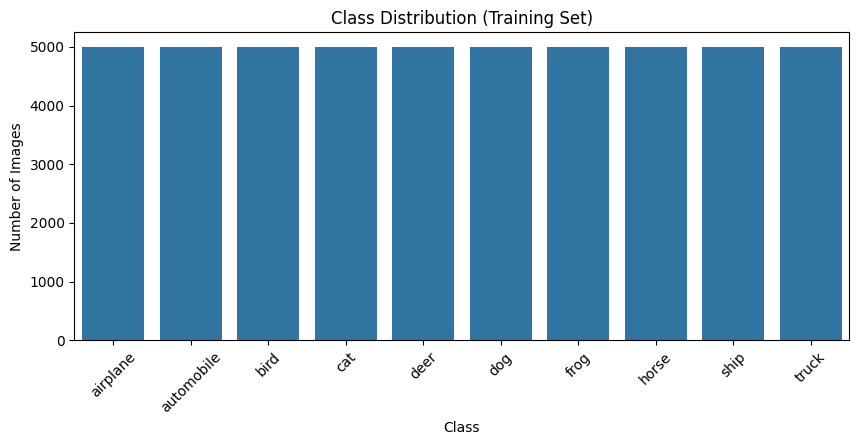

In [4]:
import numpy as np

labels = np.array(train_dataset.targets)
class_names = train_dataset.classes

counts = [(labels == i).sum() for i in range(len(class_names))]

plt.figure(figsize=(10,4))
sns.barplot(x=class_names, y=counts)
plt.xticks(rotation=45)
plt.title("Class Distribution (Training Set)")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.show()

## Exempelbilder från träningsdatan

Nedan visas några bilder från träningsdatan tillsammans med deras klass. 
Bilderna är små (32x32 pixlar), vilket innebär att modellen måste lära sig 
att känna igen objekt även med begränsad detaljnivå.


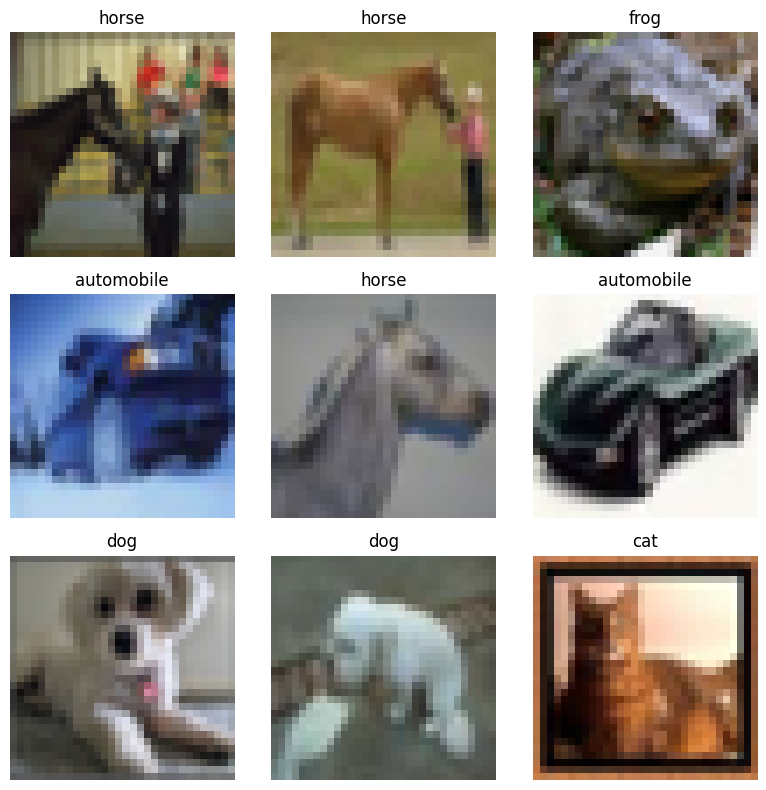

In [5]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].permute(1,2,0))
    plt.title(train_dataset.classes[labels[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()


# CIFAR-10 Experiments

I denna del genomförs experiment med olika hyperparametrar 
för att analysera hur de påverkar modellens prestanda.

Fokus ligger på att undersöka hur learning rate och antal epochs 
påverkar accuracy.


## Setup

Importerar nödvändiga bibliotek och projektets moduler.


In [6]:
import sys
from pathlib import Path

# Lägg till projektets root i sys.path
sys.path.append(str(Path().resolve().parent))

import torch

from src.dataset import get_dataloaders
from src.train import train_model
from src.evaluate import evaluate_model
from src.model import SimpleClassifier

## Device

Vi kontrollerar om GPU finns tillgänglig. 
Om inte används CPU för träning och utvärdering.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## Experimentfunktion

Funktionen tränar och utvärderar modellen 
med angivna hyperparametrar och returnerar accuracy.

In [8]:
def run_experiment(lr, epochs, batch_size=64):

    print(f"\nRunning experiment: lr={lr}, epochs={epochs}")

    train_loader, test_loader = get_dataloaders(batch_size=batch_size)

    model = SimpleClassifier().to(device)

    model = train_model(
        model,
        train_loader,
        device,
        epochs=epochs,
        lr=lr
    )

    accuracy = evaluate_model(model, test_loader, device)

    print(f"Test Accuracy: {accuracy:.4f}")

    return accuracy

## Körning av experiment

Vi testar tre olika learning rates för att undersöka hur 
inlärningshastigheten påverkar modellens accuracy.

Antal epochs hålls konstant (5) för att isolera effekten av learning rate.

In [9]:
results = []

experiments = [
    {"lr": 0.001, "epochs": 5},
    {"lr": 0.01, "epochs": 5},
    {"lr": 0.0001, "epochs": 5},
]

for exp in experiments:
    acc = run_experiment(lr=exp["lr"], epochs=exp["epochs"])
    results.append({
        "lr": exp["lr"],
        "epochs": exp["epochs"],
        "accuracy": acc
    })



Running experiment: lr=0.001, epochs=5
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5 - Loss: 1.8843
Epoch 2/5 - Loss: 1.7044
Epoch 3/5 - Loss: 1.6342
Epoch 4/5 - Loss: 1.5947
Epoch 5/5 - Loss: 1.5664
Test Accuracy: 0.4469

Running experiment: lr=0.01, epochs=5
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5 - Loss: 2.2810
Epoch 2/5 - Loss: 2.1043
Epoch 3/5 - Loss: 2.0962
Epoch 4/5 - Loss: 2.0885
Epoch 5/5 - Loss: 2.0873
Test Accuracy: 0.1777

Running experiment: lr=0.0001, epochs=5
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5 - Loss: 1.9473
Epoch 2/5 - Loss: 1.7988
Epoch 3/5 - Loss: 1.7380
Epoch 4/5 - Loss: 1.6961
Epoch 5/5 - Loss: 1.6594
Test Accuracy: 0.4174


## Körning av experiment

Vi testar tre olika learning rates för att undersöka hur 
inlärningshastigheten påverkar modellens accuracy.

Antal epochs hålls konstant (5) för att isolera effekten av learning rate.

In [10]:
import pandas as pd

df = pd.DataFrame(results)
df = df.sort_values("accuracy", ascending=False)
df["accuracy"] = df["accuracy"].round(4)

df

,lr,epochs,accuracy
0,0.0010,5,0.4469
2,0.0001,5,0.4174
1,0.0100,5,0.1777


In [11]:
best = df.iloc[0]

print("Best experiment:")
print(best)

Best experiment:
lr          0.0010
epochs      5.0000
accuracy    0.4469
Name: 0, dtype: float64


### Analys

Learning rate = 0.001 gav högst accuracy (~0.44) 
och valdes därför som bästa hyperparameter.

Learning rate = 0.0001 gav också stabil träning (~0.42),
men konvergerade långsammare inom 5 epochs.

Learning rate = 0.01 var för hög och resulterade i låg accuracy (~0.10),
vilket tyder på instabil träning och för stora gradientsteg.

Resultaten visar tydligt att learning rate har stor påverkan
på modellens konvergens och prestanda.
